In [8]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [50]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal

sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

load_and_register_tasks()
dataset = pickle.load(open("../../dataset.pkl", "rb"))
train_set, test_set = dataset.random_split_within_task(0.9)

# tenset_model = XGBModelInternal()
# tenset_model.fit_base(train_set, valid_set=test_set)

Fit a xgb booster. Train size: 3600


/root/work/tenset/.venv/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


In [52]:
# SegmentDataLoader 패턴에 맞춰 데이터 준비
raw_features = list(dataset.features.values())
raw_throughputs = list(dataset.throughputs.values())

# 가변 길이 features와 labels를 리스트로 저장
features_list = []  # 각 샘플의 feature (seq_len, feature_dim)
costs = []
segment_sizes_list = []  # 각 샘플의 segment 길이
for raw_feature, raw_throughput in zip(raw_features, raw_throughputs):
    for feature, throughput in zip(raw_feature, raw_throughput):
        if feature.shape[0] != 1 and throughput > 1e-10 :  # segment 길이가 1이 아닌 것만
            features_list.append(feature)
            # costs.append(-np.log(throughput))
            costs.append(throughput)
            segment_sizes_list.append(feature.shape[0])

# numpy array로 변환
costs = np.array(costs, dtype=np.float32)
segment_sizes = np.array(segment_sizes_list, dtype=np.int32)

# 모든 features를 flatten (SegmentDataLoader 방식)
flatten_features = np.concatenate(features_list, axis=0).astype(np.float32)

print(f"총 샘플 수: {len(costs)}")
print(f"Flatten된 features shape: {flatten_features.shape}")
print(f"Segment sizes - Min: {segment_sizes.min()}, Max: {segment_sizes.max()}, Mean: {segment_sizes.mean():.2f}")

총 샘플 수: 3464
Flatten된 features shape: (27712, 164)
Segment sizes - Min: 8, Max: 8, Mean: 8.00


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentRegressionDataset:
    """SegmentDataLoader 패턴을 따르는 데이터셋"""
    def __init__(self, segment_sizes, features, labels, batch_size, device, 
                 fea_norm_vec=None, shuffle=False, seed=42):
        self.device = device
        self.shuffle = shuffle
        self.seed = seed
        self.number = len(labels)
        self.batch_size = batch_size
        
        self.segment_sizes = torch.tensor(segment_sizes, dtype=torch.int32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        
        if fea_norm_vec is not None:
            self.normalize(fea_norm_vec)
        
        self.feature_offsets = (
            torch.cumsum(self.segment_sizes, 0, dtype=torch.int32) - self.segment_sizes
        ).cpu().numpy()
        
        self.iter_order = self.pointer = None
        self.rng = np.random.RandomState(seed)
    
    def normalize(self, norm_vector=None):
        if norm_vector is None:
            norm_vector = torch.ones((self.features.shape[1],))
            for i in range(self.features.shape[1]):
                max_val = self.features[:, i].max().item()
                if max_val > 0:
                    norm_vector[i] = max_val
        self.features /= norm_vector
        return norm_vector
    
    def __iter__(self):
        if self.shuffle:
            self.iter_order = torch.from_numpy(self.rng.permutation(self.number))
        else:
            self.iter_order = torch.arange(self.number)
        self.pointer = 0
        return self
    
    def __next__(self):
        if self.pointer >= self.number:
            raise StopIteration
        
        batch_indices = self.iter_order[self.pointer: self.pointer + self.batch_size]
        self.pointer += self.batch_size
        return self._fetch_indices(batch_indices)
    
    def _fetch_indices(self, indices):
        segment_sizes = self.segment_sizes[indices]
        
        feature_offsets = self.feature_offsets[indices]
        feature_indices = np.empty((segment_sizes.sum().item(),), dtype=np.int32)
        ct = 0
        for offset, seg_size in zip(feature_offsets, segment_sizes.numpy()):
            feature_indices[ct: ct + seg_size] = np.arange(offset, offset + seg_size, 1)
            ct += seg_size
        
        features = self.features[feature_indices]
        labels = self.labels[indices]
        return (x.to(self.device) for x in (segment_sizes, features, labels))
    
    def __len__(self):
        return self.number


# Train/Val 분할
n_samples = len(costs)
indices = np.arange(n_samples)
train_indices, val_indices = train_test_split(indices, test_size=0.2, shuffle=False)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features_list[i] for i in train_indices]
val_feature_list = [features_list[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"훈련 샘플 수: {len(train_labels)}, 검증 샘플 수: {len(val_labels)}")
print(f"훈련 flatten features: {train_flatten_features.shape}")
print(f"검증 flatten features: {val_flatten_features.shape}")

# 정규화
fea_norm_vec = torch.ones((train_flatten_features.shape[1],))
for i in range(train_flatten_features.shape[1]):
    max_val = float(train_flatten_features[:, i].max())
    if max_val > 0:
        fea_norm_vec[i] = max_val

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = SegmentRegressionDataset(
    train_segment_sizes, train_flatten_features, train_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=True, seed=SEED
)
val_loader = SegmentRegressionDataset(
    val_segment_sizes, val_flatten_features, val_labels,
    batch_size=128, device=device, fea_norm_vec=fea_norm_vec, shuffle=False, seed=SEED
)

X_train = train_flatten_features
X_val = val_flatten_features
y_train = train_labels
y_val = val_labels
train_dataset = train_loader
val_dataset = val_loader

훈련 샘플 수: 2771, 검증 샘플 수: 693
훈련 flatten features: (22168, 164)
검증 flatten features: (5544, 164)


## VAE Feature Pre-training (Reconstruction + β·KLD)

Feature만 입력으로 사용하여 VAE encoder representation을 먼저 학습합니다.
- Reconstruction loss: MSE로 원본 feature를 복원
- KL Divergence: latent 분포를 N(0, I)에 가깝게 정규화
- β 자동 탐색: 1e-3~1e-2 범위에서 최적값 탐색

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import r2_score
import random

# 시드 고정
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

class SegmentVAE(nn.Module):
    """
    Segment-level VAE:
    1. Segment Encoder: 각 row를 hidden_dim으로 변환
    2. Segment Sum: row들을 segment별로 합산
    3. VAE: 합산된 벡터를 encode → decode (reconstruction)
    """
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, dropout=0.1):
        super(SegmentVAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Segment Encoder (VAE 전에 적용) ==========
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # ========== VAE Encoder (segment sum 후 적용) ==========
        self.norm = nn.BatchNorm1d(hidden_dim)
        
        # Residual 레이어들
        self.l0 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.l1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE latent parameters
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== VAE Decoder (hidden_dim으로 reconstruction) ==========
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),  # 출력: segment sum 벡터 (hidden_dim)
        )
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, h):
        """VAE Encoder: segment sum 벡터 → (mean, logvar)"""
        # BatchNorm
        h = self.norm(h)
        
        # Residual connections
        h = self.l0(h) + h
        h = self.l1(h) + h
        
        # Latent parameters
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z):
        """VAE Decoder: latent z → reconstructed segment sum 벡터"""
        return self.decoder(z)
    
    def forward(self, segment_sizes, features):
        """
        Forward pass:
        1. Segment Encoder: features → hidden
        2. Segment Sum: hidden → segment-level 벡터
        3. VAE: encode → reparameterize → decode
        """
        # 1. Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # 2. Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # 3. VAE Encode
        mean, logvar = self.encode(segment_sum_vec)
        
        # 4. Reparameterize
        z = self.reparameterize(mean, logvar)
        
        # 5. VAE Decode (reconstruct segment sum 벡터)
        recon = self.decode(z)  # (n_seg, hidden_dim)
        
        return mean, logvar, z, recon, segment_sum_vec


def vae_loss(recon, original, mean, logvar, beta):
    """
    VAE Loss = Reconstruction Loss + β * KL Divergence
    - Reconstruction: MSE between original and reconstructed segment sum 벡터
    - KLD: D_KL(q(z|x) || p(z)), where p(z) = N(0, I)
    """
    recon_loss = F.mse_loss(recon, original, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kld_loss
    return total_loss, recon_loss, kld_loss


print("Segment VAE 모델 정의 완료!")
print(f"- Input dim: {train_flatten_features.shape[1]}")
print(f"- Hidden dim: 256")
print(f"- Latent dim: 64")
print("Flow: features → segment_encoder → segment_sum → VAE (encode/decode)")

Segment VAE 모델 정의 완료!
- Input dim: 164
- Hidden dim: 256
- Latent dim: 64
Flow: features → segment_encoder → segment_sum → VAE (encode/decode)


In [55]:
# ============================================================
# VAE 기반 Cost Predictor 모델 정의
# ============================================================
# Pretrained VAE encoder + Cost Predictor
# 전체 forward 경로가 미분 가능해야 함

class VAECostPredictor(nn.Module):
    """
    VAE 기반 Cost Regression 모델
    
    구조:
    - input → segment_encoder → segment_sum → VAE encoder → z → cost_predictor → cost
    
    특징:
    - Pretrained VAE encoder를 finetune (작은 learning rate)
    - Cost predictor는 더 큰 learning rate로 학습
    - 전체 forward 경로가 완전히 미분 가능 (detach, stop_grad 없음)
    """
    
    def __init__(self, input_dim, hidden_dim=256, latent_dim=128, 
                 predictor_hidden=256, predictor_layers=3, dropout=0.1):
        super(VAECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # ========== Pretrained VAE Encoder 부분 ==========
        # Segment Encoder
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE Encoder layers
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.l0 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # ========== Cost Predictor (새로 학습) ==========
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.BatchNorm1d(predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        
        self.cost_predictor = nn.Sequential(*predictor_modules)
        
    def segment_sum(self, segment_sizes, features):
        """SegmentSum: 각 segment 내 row들을 합산"""
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        
        segment_indices = torch.repeat_interleave(
            torch.arange(n_seg, device=device), segment_sizes
        )
        
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0,
            segment_indices.view(-1, 1).expand(-1, n_dim),
            features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        """
        Full encoding path: features → z
        완전히 미분 가능
        """
        # Segment Encoder
        h = self.segment_encoder(features)  # (total_rows, hidden_dim)
        
        # Segment Sum
        segment_sum_vec = self.segment_sum(segment_sizes, h)  # (n_seg, hidden_dim)
        
        # VAE Encoder
        h = self.norm(segment_sum_vec)
        h = self.l0(h) + h  # Residual
        h = self.l1(h) + h  # Residual
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        return mean, logvar, segment_sum_vec
    
    def reparameterize(self, mean, logvar):
        """Reparameterization trick - 미분 가능"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def predict_cost(self, z):
        """z → cost prediction - 완전히 미분 가능"""
        return self.cost_predictor(z).squeeze(-1)
    
    def forward(self, segment_sizes, features, use_mean=False):
        """
        Forward pass: input → z → cost
        
        Args:
            use_mean: True면 reparameterize 대신 mean 사용 (inference용)
        
        Returns:
            cost_pred: 예측된 cost
            mean: latent mean
            logvar: latent log-variance
            z: sampled/mean latent vector
        """
        mean, logvar, segment_sum_vec = self.encode(segment_sizes, features)
        
        if use_mean:
            z = mean  # Inference시 deterministic
        else:
            z = self.reparameterize(mean, logvar)  # Training시 stochastic
        
        cost_pred = self.predict_cost(z)
        
        return cost_pred, mean, logvar, z
    
    def get_encoder_params(self):
        """Encoder 파라미터 (작은 lr)"""
        encoder_params = []
        encoder_params.extend(self.segment_encoder.parameters())
        encoder_params.extend(self.norm.parameters())
        encoder_params.extend(self.l0.parameters())
        encoder_params.extend(self.l1.parameters())
        encoder_params.extend(self.fc_mean.parameters())
        encoder_params.extend(self.fc_logvar.parameters())
        return encoder_params
    
    def get_predictor_params(self):
        """Predictor 파라미터 (큰 lr)"""
        return self.cost_predictor.parameters()
    
    def load_pretrained_encoder(self, checkpoint):
        """Pretrained VAE encoder 가중치 로드"""
        
        # VAE state dict에서 encoder 관련 부분만 추출
        if 'model_state_dict' in checkpoint:
            vae_state = checkpoint['model_state_dict']
        else:
            vae_state = checkpoint
        
        # 매칭되는 키만 로드
        encoder_keys = ['segment_encoder', 'norm', 'l0', 'l1', 'fc_mean', 'fc_logvar']
        own_state = self.state_dict()
        
        loaded_keys = []
        for name, param in vae_state.items():
            if any(name.startswith(k) for k in encoder_keys):
                if name in own_state and own_state[name].shape == param.shape:
                    own_state[name].copy_(param)
                    loaded_keys.append(name)
        
        print(f"Loaded {len(loaded_keys)} parameters from pretrained VAE")
        return checkpoint.get('config', {}), checkpoint.get('metrics', {})


print("VAECostPredictor 모델 정의 완료!")
print("특징:")
print("  - Pretrained VAE encoder + Cost predictor")
print("  - 전체 forward 경로 미분 가능")
print("  - Encoder/Predictor 분리 학습률 지원")

VAECostPredictor 모델 정의 완료!
특징:
  - Pretrained VAE encoder + Cost predictor
  - 전체 forward 경로 미분 가능
  - Encoder/Predictor 분리 학습률 지원


In [56]:
# ============================================================
# Loss 함수 정의 (vae_reg_param_ansor.ipynb 스타일)
# ============================================================
# total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss

def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """
    기본 회귀 손실 (MSE 또는 MAE)
    """
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    else:  # mae
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """
    Pairwise ranking loss: 실제 cost 순서를 예측이 유지하도록.
    cost_true[i] < cost_true[j] 이면 cost_pred[i] < cost_pred[j] + margin
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    # 모든 쌍에 대해 ranking loss 계산
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx  # upper triangular only
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    # label: 1 if true_i < true_j, -1 otherwise
    labels = torch.sign(true_j - true_i).float()
    
    # Margin ranking loss
    loss = F.margin_ranking_loss(pred_j.view(-1), pred_i.view(-1), labels.view(-1), margin=margin)
    return loss


def smooth_loss_fn(model, z, noise_std=0.1):
    """
    Smoothness loss: z에 작은 노이즈를 더했을 때 예측이 크게 변하지 않도록.
    """
    z_noisy = z + noise_std * torch.randn_like(z)
    
    cost_original = model.predict_cost(z)
    cost_noisy = model.predict_cost(z_noisy)
    
    smooth_loss = F.mse_loss(cost_original, cost_noisy)
    return smooth_loss


def kld_loss_fn(mean, logvar):
    """
    KL Divergence: q(z|x) || N(0, I)
    """
    kld = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return kld


def compute_total_loss(model, segment_sizes, features, labels, config, return_components=False):
    """
    Total loss 계산 (Segment 기반 데이터용).
    total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss
    """
    # Forward pass
    cost_pred, mean, logvar, z = model(segment_sizes, features, use_mean=False)
    
    # Individual losses
    reg = reg_loss_fn(cost_pred, labels, loss_type=config.get('loss_type', 'mse'))
    pair = pair_loss_fn(cost_pred.view(-1), labels.view(-1), margin=config.get('margin', 0.1))
    smooth = smooth_loss_fn(model, z, noise_std=config.get('noise_std', 0.1))
    kld = kld_loss_fn(mean, logvar)
    
    # Weighted sum
    total = reg + config['lambda_pair'] * pair + config['gamma'] * smooth + config['beta'] * kld
    
    if return_components:
        return total, {
            'reg_loss': reg.item(),
            'pair_loss': pair.item(),
            'smooth_loss': smooth.item(),
            'kld_loss': kld.item(),
            'total_loss': total.item(),
        }
    return total


print("✅ Loss functions 정의 완료")
print("   - reg_loss_fn: MSE/MAE 회귀 손실")
print("   - pair_loss_fn: Margin ranking 순서 손실")
print("   - smooth_loss_fn: Latent space smoothness 손실")
print("   - kld_loss_fn: KL divergence 정규화")
print("   - compute_total_loss: 통합 손실 함수")

✅ Loss functions 정의 완료
   - reg_loss_fn: MSE/MAE 회귀 손실
   - pair_loss_fn: Margin ranking 순서 손실
   - smooth_loss_fn: Latent space smoothness 손실
   - kld_loss_fn: KL divergence 정규화
   - compute_total_loss: 통합 손실 함수


In [57]:
# ============================================================
# Phase 단위 학습 인프라 (vae_reg_param_ansor.ipynb 스타일)
# ============================================================
import random
from collections import deque
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


class SegmentReplayBuffer:
    """Segment 기반 데이터를 위한 경험 재생 버퍼"""
    def __init__(self, max_size=10000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, indices, features_list, segment_sizes_list, labels):
        """배치 인덱스와 해당 데이터 추가"""
        for i, idx in enumerate(indices):
            self.buffer.append({
                'idx': idx,
                'features': features_list[i].cpu() if isinstance(features_list[i], torch.Tensor) else features_list[i],
                'segment_size': segment_sizes_list[i],
                'label': labels[i].cpu() if isinstance(labels[i], torch.Tensor) else labels[i],
            })
    
    def sample(self, n):
        """n개 샘플 랜덤 추출"""
        if len(self.buffer) < n:
            n = len(self.buffer)
        samples = random.sample(list(self.buffer), n)
        return samples
    
    def __len__(self):
        return len(self.buffer)


class GradientMonitor:
    """z에 대한 gradient 통계 모니터링"""
    def __init__(self):
        self.history = {
            'grad_norm_mean': [],
            'grad_norm_std': [],
            'grad_norm_max': [],
            'grad_norm_min': [],
        }
    
    def record(self, model, sample_loader, device, n_samples=100):
        """샘플에 대한 gradient 통계 기록"""
        model.eval()
        
        all_grad_norms = []
        sample_count = 0
        
        for segment_sizes, features, labels in sample_loader:
            if sample_count >= n_samples:
                break
            
            batch_size = segment_sizes.shape[0]
            
            # Forward pass with gradient tracking
            mean, logvar, _ = model.encode(segment_sizes, features)
            z = mean.detach().clone().requires_grad_(True)
            
            # Cost prediction
            cost_pred = model.predict_cost(z)
            
            # 각 샘플에 대해 gradient 계산
            for i in range(min(batch_size, n_samples - sample_count)):
                if z.grad is not None:
                    z.grad.zero_()
                cost_pred[i].backward(retain_graph=True)
                grad = z.grad[i].clone()
                all_grad_norms.append(grad.norm().item())
            
            sample_count += min(batch_size, n_samples - sample_count)
        
        grad_norms = np.array(all_grad_norms)
        
        self.history['grad_norm_mean'].append(grad_norms.mean())
        self.history['grad_norm_std'].append(grad_norms.std())
        self.history['grad_norm_max'].append(grad_norms.max())
        self.history['grad_norm_min'].append(grad_norms.min())
        
        model.train()
        return {
            'mean': grad_norms.mean(),
            'std': grad_norms.std(),
            'max': grad_norms.max(),
            'min': grad_norms.min(),
        }


class TrainingLogger:
    """학습 로그 기록"""
    def __init__(self):
        self.phase_logs = []
        self.val_logs = []
    
    def log_phase(self, phase, losses, grad_stats=None):
        entry = {
            'phase': phase,
            **losses,
        }
        if grad_stats:
            entry.update({f'grad_{k}': v for k, v in grad_stats.items()})
        self.phase_logs.append(entry)
    
    def log_validation(self, phase, metrics):
        self.val_logs.append({
            'phase': phase,
            **metrics,
        })
    
    def get_recent_val_mse(self, n=3):
        """최근 n개 phase의 validation MSE 반환"""
        if len(self.val_logs) < n:
            return [log['val_mse'] for log in self.val_logs]
        return [log['val_mse'] for log in self.val_logs[-n:]]


def evaluate_model_phase(model, val_loader, device, config):
    """
    전체 validation set에 대한 평가.
    Deterministic mode (z = mean) 사용.
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    loss_components = {'reg_loss': 0, 'pair_loss': 0, 'smooth_loss': 0, 'kld_loss': 0}
    n_samples = 0
    
    with torch.no_grad():
        for segment_sizes, features, labels in val_loader:
            # Deterministic prediction
            cost_pred, mean, logvar, z = model(segment_sizes, features, use_mean=True)
            
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
            
            # Loss 계산 (eval에서는 use_mean=True로 별도 계산)
            reg = reg_loss_fn(cost_pred, labels, loss_type=config.get('loss_type', 'mse'))
            pair = pair_loss_fn(cost_pred.view(-1), labels.view(-1), margin=config.get('margin', 0.1))
            smooth = smooth_loss_fn(model, z, noise_std=config.get('noise_std', 0.1))
            kld = kld_loss_fn(mean, logvar)
            
            batch_size = segment_sizes.shape[0]
            loss_components['reg_loss'] += reg.item() * batch_size
            loss_components['pair_loss'] += pair.item() * batch_size
            loss_components['smooth_loss'] += smooth.item() * batch_size
            loss_components['kld_loss'] += kld.item() * batch_size
            total_loss += (reg + config['lambda_pair'] * pair + config['gamma'] * smooth + config['beta'] * kld).item() * batch_size
            n_samples += batch_size
    
    # 평균 계산
    for k in loss_components:
        loss_components[k] /= n_samples
    total_loss /= n_samples
    
    # Metrics 계산
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    metrics = {
        'val_mse': mean_squared_error(all_targets, all_preds),
        'val_mae': mean_absolute_error(all_targets, all_preds),
        'val_r2': r2_score(all_targets, all_preds),
        'val_loss': total_loss,
        **{f'val_{k}': v for k, v in loss_components.items()},
    }
    
    model.train()
    return metrics, all_preds, all_targets


def train_phase_segment(model, phase_indices, train_features_list, train_segment_sizes, 
                        train_labels, optimizer, device, config, fea_norm_vec=None):
    """
    Segment 기반 데이터를 위한 Phase 단위 학습.
    """
    model.train()
    
    # Phase 데이터 준비
    phase_features = [train_features_list[i] for i in phase_indices]
    phase_segment_sizes = train_segment_sizes[phase_indices]
    phase_labels = train_labels[phase_indices]
    
    # Flatten features
    flatten_features = np.concatenate(phase_features, axis=0).astype(np.float32)
    
    # Tensor 변환
    segment_sizes_tensor = torch.tensor(phase_segment_sizes, dtype=torch.int32).to(device)
    features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
    labels_tensor = torch.tensor(phase_labels, dtype=torch.float32).to(device)
    
    # 정규화 적용
    if fea_norm_vec is not None:
        features_tensor = features_tensor / fea_norm_vec.to(device)
    
    # Forward & Loss
    total_loss, components = compute_total_loss(
        model, segment_sizes_tensor, features_tensor, labels_tensor, config, return_components=True
    )
    
    # Backward
    optimizer.zero_grad()
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    return components


print("✅ Phase 단위 학습 인프라 정의 완료")
print("   - SegmentReplayBuffer: Segment 기반 경험 재생 버퍼")
print("   - GradientMonitor: z-gradient 통계 모니터링")
print("   - TrainingLogger: 학습 로그 기록")
print("   - evaluate_model_phase: Validation 평가")
print("   - train_phase_segment: Segment 데이터용 Phase 학습")

✅ Phase 단위 학습 인프라 정의 완료
   - SegmentReplayBuffer: Segment 기반 경험 재생 버퍼
   - GradientMonitor: z-gradient 통계 모니터링
   - TrainingLogger: 학습 로그 기록
   - evaluate_model_phase: Validation 평가
   - train_phase_segment: Segment 데이터용 Phase 학습


## Regression with Pre-trained VAE Encoder

사전학습된 VAE encoder를 사용하여 regression 모델을 학습합니다.
- VAE encoder의 latent representation (z)을 사용
- Regression head만 추가하여 cost 예측

In [58]:
# ============================================================
# 🎯 2 Phase 최적화 학습 (R² ≈ 0.8 목표)
# ============================================================
# 핵심 전략:
# 1. Phase당 더 많은 샘플 사용 (128~256)
# 2. 각 Phase 내에서 여러 번 반복 학습 (mini-epochs)
# 3. 학습 안 쓴 train 데이터 + val 데이터로 평가
# 4. 적극적인 학습률과 loss 가중치

import copy

def evaluate_on_all_remaining(model, train_feature_list, train_segment_sizes, train_labels,
                               val_feature_list, val_segment_sizes, val_labels,
                               used_indices, fea_norm_vec, device, config):
    """
    학습에 사용되지 않은 train 데이터 + 전체 val 데이터로 평가
    """
    model.eval()
    
    # 학습에 사용되지 않은 train 인덱스
    all_train_indices = set(range(len(train_labels)))
    unused_train_indices = list(all_train_indices - set(used_indices))
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        # 1. 사용되지 않은 train 데이터 평가
        if len(unused_train_indices) > 0:
            # 배치 단위로 처리
            batch_size = 256
            for i in range(0, len(unused_train_indices), batch_size):
                batch_indices = unused_train_indices[i:i+batch_size]
                batch_features = [train_feature_list[idx] for idx in batch_indices]
                batch_segment_sizes = train_segment_sizes[batch_indices]
                batch_labels = train_labels[batch_indices]
                
                # Flatten features
                flatten_features = np.concatenate(batch_features, axis=0).astype(np.float32)
                
                # Tensor 변환
                segment_sizes_tensor = torch.tensor(batch_segment_sizes, dtype=torch.int32).to(device)
                features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
                labels_tensor = torch.tensor(batch_labels, dtype=torch.float32).to(device)
                
                # 정규화
                if fea_norm_vec is not None:
                    features_tensor = features_tensor / fea_norm_vec.to(device)
                
                # 예측
                cost_pred, _, _, _ = model(segment_sizes_tensor, features_tensor, use_mean=True)
                
                all_preds.append(cost_pred.cpu().numpy())
                all_targets.append(labels_tensor.cpu().numpy())
        
        # 2. 전체 val 데이터 평가
        batch_size = 256
        for i in range(0, len(val_labels), batch_size):
            end_i = min(i + batch_size, len(val_labels))
            batch_features = val_feature_list[i:end_i]
            batch_segment_sizes = val_segment_sizes[i:end_i]
            batch_labels = val_labels[i:end_i]
            
            # Flatten features
            flatten_features = np.concatenate(batch_features, axis=0).astype(np.float32)
            
            # Tensor 변환
            segment_sizes_tensor = torch.tensor(batch_segment_sizes, dtype=torch.int32).to(device)
            features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
            labels_tensor = torch.tensor(batch_labels, dtype=torch.float32).to(device)
            
            # 정규화
            if fea_norm_vec is not None:
                features_tensor = features_tensor / fea_norm_vec.to(device)
            
            # 예측
            cost_pred, _, _, _ = model(segment_sizes_tensor, features_tensor, use_mean=True)
            
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(labels_tensor.cpu().numpy())
    
    # 전체 결과 합치기
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    
    # 메트릭 계산
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    
    # Pairwise ranking accuracy
    n_samples = min(1000, len(all_preds))
    sample_indices = np.random.choice(len(all_preds), n_samples, replace=False)
    correct_pairs = 0
    total_pairs = 0
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            idx_i, idx_j = sample_indices[i], sample_indices[j]
            if all_targets[idx_i] != all_targets[idx_j]:
                pred_order = all_preds[idx_i] < all_preds[idx_j]
                true_order = all_targets[idx_i] < all_targets[idx_j]
                if pred_order == true_order:
                    correct_pairs += 1
                total_pairs += 1
    
    rank_accuracy = correct_pairs / total_pairs if total_pairs > 0 else 0
    
    model.train()
    
    return {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rank_accuracy': rank_accuracy,
        'n_unused_train': len(unused_train_indices),
        'n_val': len(val_labels),
        'n_total': len(unused_train_indices) + len(val_labels),
        'predictions': all_preds,
        'targets': all_targets,
    }


def train_phase_optimized(model, train_feature_list, train_segment_sizes, train_labels,
                            val_feature_list, val_segment_sizes, val_labels,
                            fea_norm_vec, device, config,
                            samples_per_phase=128, mini_epochs=10, target_r2=0.8, phases=1):
    """
    Phase 최적화 학습
    
    Args:
        samples_per_phase: Phase당 샘플 수
        mini_epochs: 각 Phase 내 반복 횟수
        target_r2: 목표 R² 값
    """
    print("=" * 70)
    print(f"🎯 {phases} Phase 최적화 학습 시작")
    print(f"   Samples per phase: {samples_per_phase}")
    print(f"   Mini-epochs per phase: {mini_epochs}")
    print(f"   Target R²: {target_r2}")
    print("=" * 70)
    
    # 인덱스 셔플
    all_indices = np.arange(len(train_labels))
    # np.random.shuffle(all_indices)
    
    # 사용된 인덱스 추적
    used_indices = []
    
    best_r2 = -float('inf')
    best_state = None
    history = []
    
    # Optimizer 설정 (적극적인 학습률)
    optimizer = torch.optim.AdamW([
        {'params': model.get_encoder_params(), 'lr': config['encoder_lr']},
        {'params': model.get_predictor_params(), 'lr': config['predictor_lr']}
    ], weight_decay=1e-5)
    
    # 초기 평가
    initial_metrics = evaluate_on_all_remaining(
        model, train_feature_list, train_segment_sizes, train_labels,
        val_feature_list, val_segment_sizes, val_labels,
        [], fea_norm_vec, device, config
    )
    print(f"\n📊 초기 상태:")
    print(f"   R²: {initial_metrics['r2']:.4f}, Rank Acc: {initial_metrics['rank_accuracy']:.4f}")
    print(f"   MSE: {initial_metrics['mse']:.4f}, MAE: {initial_metrics['mae']:.4f}")
    
    # ========== Phase 1 & 2 학습 ==========
    for phase in range(phases):
        print(f"\n{'='*70}")
        print(f"📌 Phase {phase + 1} 학습")
        print(f"{'='*70}")
        
        # Phase 샘플 선택
        start_idx = phase * samples_per_phase
        end_idx = min(start_idx + samples_per_phase, len(all_indices))
        phase_indices = all_indices[start_idx:end_idx].tolist()
        used_indices.extend(phase_indices)
        
        print(f"   학습 샘플: {len(phase_indices)}개")
        print(f"   총 사용된 샘플: {len(used_indices)}개")
        
        # Phase 데이터 준비
        phase_features = [train_feature_list[i] for i in phase_indices]
        phase_segment_sizes = train_segment_sizes[phase_indices]
        phase_labels = train_labels[phase_indices]
        
        # Flatten features
        flatten_features = np.concatenate(phase_features, axis=0).astype(np.float32)
        
        # Tensor 변환
        segment_sizes_tensor = torch.tensor(phase_segment_sizes, dtype=torch.int32).to(device)
        features_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
        labels_tensor = torch.tensor(phase_labels, dtype=torch.float32).to(device)
        
        # 정규화
        if fea_norm_vec is not None:
            features_tensor = features_tensor / fea_norm_vec.to(device)
        
        # Mini-epochs 학습
        for epoch in range(mini_epochs):
            model.train()
            optimizer.zero_grad()
            
            # Forward
            total_loss, components = compute_total_loss(
                model, segment_sizes_tensor, features_tensor, labels_tensor, 
                config, return_components=True
            )
            
            # Backward
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # 중간 평가 (5 epoch마다)
            if (epoch + 1) % 5 == 0 or epoch == mini_epochs - 1:
                metrics = evaluate_on_all_remaining(
                    model, train_feature_list, train_segment_sizes, train_labels,
                    val_feature_list, val_segment_sizes, val_labels,
                    used_indices, fea_norm_vec, device, config
                )
                
                print(f"   [Epoch {epoch+1}/{mini_epochs}] "
                      f"Loss: {components['total_loss']:.4f}, "
                      f"R²: {metrics['r2']:.4f}, Rank: {metrics['rank_accuracy']:.4f}")
                
                history.append({
                    'phase': phase + 1,
                    'epoch': epoch + 1,
                    **metrics,
                    **components
                })
                
                # Best model 저장
                if metrics['r2'] > best_r2:
                    best_r2 = metrics['r2']
                    best_state = copy.deepcopy(model.state_dict())
                
                # 목표 달성 체크
                if metrics['r2'] >= target_r2:
                    print(f"\n   🎉 목표 R² {target_r2} 달성! (R² = {metrics['r2']:.4f})")
    
    # Best model 복원
    if best_state is not None:
        model.load_state_dict(best_state)
    
    # 최종 평가
    final_metrics = evaluate_on_all_remaining(
        model, train_feature_list, train_segment_sizes, train_labels,
        val_feature_list, val_segment_sizes, val_labels,
        used_indices, fea_norm_vec, device, config
    )
    
    print(f"\n{'='*70}")
    print(f"🏆 {phases} Phase 학습 완료!")
    print(f"{'='*70}")
    print(f"   Best R²: {best_r2:.4f}")
    print(f"   Final R²: {final_metrics['r2']:.4f}")
    print(f"   Final Rank Accuracy: {final_metrics['rank_accuracy']:.4f}")
    print(f"   사용된 샘플: {len(used_indices)}개 / 전체 {len(train_labels)}개")
    
    return model, history, final_metrics, used_indices


print(f"✅ Phase 최적화 학습 함수 정의 완료")

✅ Phase 최적화 학습 함수 정의 완료


In [59]:
# ============================================================
# 🚀 1 Phase로 R² 0.9 달성 도전 (Phase당 64개 샘플)
# ============================================================
# 매우 공격적인 학습 전략으로 최대 성능 도전

# 모델 초기 상태 저장 (매 실험마다 리셋용)
from glob import glob

vae_checkpoint_dir = '/root/work/tenset/scripts/pre_experiments/model_final/checkpoints/vae_medium'
vae_files = sorted(glob(f'{vae_checkpoint_dir}/vae_rank8_*.pt'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(vae_files[0], map_location=device)

model = VAECostPredictor(
    input_dim=164,
    hidden_dim=checkpoint['config']['hidden_dim'],
    latent_dim=checkpoint['config']['latent_dim'],
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.1
).to(device)
model.load_pretrained_encoder(checkpoint)

print(f"   Config: hidden_dim={checkpoint['config']['hidden_dim']}, latent_dim={checkpoint['config']['latent_dim']}")


# 파라미터 수 출력
enc_params = sum(p.numel() for p in model.get_encoder_params())
cost_params = sum(p.numel() for p in model.get_predictor_params())
print(f"\n모델 파라미터 수:")
print(f"   Encoder: {enc_params:,}")
print(f"   Cost Predictor: {cost_params:,}")
print(f"   Total: {enc_params + cost_params:,}")


# 실험 결과 저장
experiment_results = []
epochs = [200]
# R² 0.9 달성을 위한 매우 공격적인 하이퍼파라미터 조합들
for epoch in epochs:
    hp_configs = [
        # Config 1: 매우 긴 학습 + 강한 pair loss <- 별로임
        # {
        #     'name': 'ultra_long_strong_pair',
        #     'encoder_lr': 1e-5,
        #     'predictor_lr': 1e-3,
        #     'lambda_pair': 0.15,
        #     'gamma': 0.005,
        #     'beta': 0.001,
        #     'margin': 0.01,
        #     'noise_std': 0.01,
        #     'loss_type': 'mse',
            # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # Config 2: 초고속 수렴 시도
        {
            'name': 'fast_convergence',
            'encoder_lr': 5e-5,
            'predictor_lr': 5e-3,
            'lambda_pair': 0.2,
            'gamma': 0.01,
            'beta': 0.001,
            'margin': 0.005,
            'noise_std': 0.01,
            'loss_type': 'mse',
            # 'samples_per_phase': 64,
            'mini_epochs': epoch,
        },
        # # Config 3: 극단적 pair loss
        # {
        #     'name': 'extreme_pair_v2',
        #     'encoder_lr': 2e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.3,
        #     'gamma': 0.002,
        #     'beta': 0.0005,
        #     'margin': 0.005,
        #     'noise_std': 0.005,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 4: Smooth 강화 + 긴 학습
        # # {
        # #     'name': 'smooth_ultra',
        # #     'encoder_lr': 1.5e-5,
        # #     'predictor_lr': 1.5e-3,
        # #     'lambda_pair': 0.1,
        # #     'gamma': 0.02,
        # #     'beta': 0.001,
        # #     'margin': 0.02,
        # #     'noise_std': 0.02,
        # #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        # #     'mini_epochs': epoch,
        # # },
        # # Config 5: 균형 + 매우 긴 학습
        # {
        #     'name': 'balanced_ultra_long',
        #     'encoder_lr': 1e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.12,
        #     'gamma': 0.008,
        #     'beta': 0.001,
        #     'margin': 0.01,
        #     'noise_std': 0.01,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 6: Huber loss + 강한 regularization
        # {
        #     'name': 'huber_strong_reg',
        #     'encoder_lr': 2e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.15,
        #     'gamma': 0.01,
        #     'beta': 0.002,
        #     'margin': 0.01,
        #     'noise_std': 0.01,
        #     'loss_type': 'huber',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 7: 극도로 낮은 noise + 높은 pair
        # {
        #     'name': 'low_noise_high_pair',
        #     'encoder_lr': 2e-5,
        #     'predictor_lr': 2e-3,
        #     'lambda_pair': 0.25,
        #     'gamma': 0.005,
        #     'beta': 0.0005,
        #     'margin': 0.003,
        #     'noise_std': 0.002,
        #     'loss_type': 'mse',
        #     # 'samples_per_phase': 64,
        #     'mini_epochs': epoch,
        # },
        # # Config 8: 최종 극한 설정
        # # {
        # #     'name': 'ultimate_config',
        # #     'encoder_lr': 1e-5,
        # #     'predictor_lr': 1e-3,
        # #     'lambda_pair': 0.2,
        # #     'gamma': 0.015,
        # #     'beta': 0.0005,
        # #     'margin': 0.005,
        # #     'noise_std': 0.005,
        # #     'loss_type': 'mse',
        # #     'samples_per_phase': 64,
        # #     'mini_epochs': epoch,
        # # },
    ]

    print("=" * 70)
    print("🎯 R² 0.8 달성 도전 (Phase당 64개)")
    print("=" * 70)

    best_overall_r2 = 0.0
    best_overall_result = None

    for i, hp_config in enumerate(hp_configs):
        print(f"\n{'='*70}")
        print(f"[실험 {i+1}/{len(hp_configs)}] {hp_config['name']}")
        print(f"   mini_epochs={hp_config['mini_epochs']}, lambda_pair={hp_config['lambda_pair']}")
        print(f"{'='*70}")
        
        # 모델 리셋
        model = VAECostPredictor(
            input_dim=164,
            hidden_dim=checkpoint['config']['hidden_dim'],
            latent_dim=checkpoint['config']['latent_dim'],
            predictor_hidden=256,
            predictor_layers=3,
            dropout=0.1
        ).to(device)
        model.load_pretrained_encoder(checkpoint)
        
        # 학습 실행
        try:
            trained_model, history, final_metrics, used_indices = train_phase_optimized(
                model, train_feature_list, train_segment_sizes, train_labels,
                val_feature_list, val_segment_sizes, val_labels,
                fea_norm_vec, device, hp_config,
                samples_per_phase=64,
                mini_epochs=hp_config['mini_epochs'],
                target_r2=0.80
            )
            
            # 결과 저장
            result = {
                'config_name': hp_config['name'],
                'config': hp_config,
                'final_r2': final_metrics['r2'],
                'final_rank_acc': final_metrics['rank_accuracy'],
                'final_mse': final_metrics['mse'],
                'history': history,
                'used_samples': len(used_indices),
                'model_state': copy.deepcopy(trained_model.state_dict()),
            }
            experiment_results.append(result)
            
            if final_metrics['r2'] > best_overall_r2:
                best_overall_r2 = final_metrics['r2']
                best_overall_result = result
            
            # R² 0.9 달성 시 즉시 종료
            if final_metrics['r2'] >= 0.9:
                print(f"\n🎉🎉🎉 R² 0.9 달성! 실험 종료 🎉🎉🎉")
                break
            
        except Exception as e:
            print(f"   ❌ 실험 실패: {e}")
            experiment_results.append({
                'config_name': hp_config['name'],
                'config': hp_config,
                'final_r2': -1,
                'error': str(e),
            })

    # 결과 정렬 (R² 기준)
    experiment_results = sorted(experiment_results, key=lambda x: x.get('final_r2', -1), reverse=True)

    print(f"\n{'='*70}")
    print("📊 실험 결과 요약 (R² 순) - R² 0.8 도전")
    print(f"{'='*70}")
    print(f"\n{'Config':<25} {'R²':<10} {'Rank Acc':<12} {'MSE':<10} {'RMSE':<10} {'Epochs':<8}")
    print("-" * 80)
    for r in experiment_results:
        if 'error' not in r:
            achieved = "✅" if r['final_r2'] >= 0.8 else ("🔥" if r['final_r2'] >= 0.78 else "")
            rmse = np.sqrt(r['final_mse'])
            print(f"{r['config_name']:<25} {r['final_r2']:<10.4f} {r['final_rank_acc']:<12.4f} "
                f"{r['final_mse']:<10.4f} {rmse:<10.4f} {r['config']['mini_epochs']:<8} {achieved}")
        else:
            print(f"{r['config_name']:<25} FAILED")

    # 최고 결과
    best_result = experiment_results[0]
    best_rmse = np.sqrt(best_result['final_mse'])
    print(f"\n🏆 최고 설정: {best_result['config_name']}")
    print(f"   R²: {best_result['final_r2']:.4f}")
    print(f"   RMSE: {best_rmse:.4f}")
    print(f"   Rank Accuracy: {best_result['final_rank_acc']:.4f}")
    print(f"   사용 샘플: {best_result['used_samples']}개 (2 Phase x 64)")

    if best_result['final_r2'] >= 0.8:
        print(f"\n🎉🎉🎉 R² 0.8 달성 성공! 🎉🎉🎉")
    elif best_result['final_r2'] >= 0.78:
        print(f"\n🔥 R² 0.78 이상 달성! (목표 0.8까지 {0.8 - best_result['final_r2']:.4f} 부족)")
    else:
        print(f"\n⚠️ 최고 R²: {best_result['final_r2']:.4f}")

Loaded 17 parameters from pretrained VAE
   Config: hidden_dim=512, latent_dim=128

모델 파라미터 수:
   Encoder: 1,004,800
   Cost Predictor: 166,401
   Total: 1,171,201
🎯 R² 0.8 달성 도전 (Phase당 64개)

[실험 1/1] fast_convergence
   mini_epochs=200, lambda_pair=0.2
Loaded 17 parameters from pretrained VAE
🎯 1 Phase 최적화 학습 시작
   Samples per phase: 64
   Mini-epochs per phase: 200
   Target R²: 0.8

📊 초기 상태:
   R²: -1.0042, Rank Acc: 0.4217
   MSE: 0.0828, MAE: 0.2012

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개
   [Epoch 5/200] Loss: 0.5265, R²: -2.4518, Rank: 0.4817
   [Epoch 10/200] Loss: 0.1550, R²: -1.1956, Rank: 0.4776
   [Epoch 15/200] Loss: 0.0928, R²: -1.1117, Rank: 0.4971
   [Epoch 20/200] Loss: 0.0944, R²: -0.2417, Rank: 0.5289
   [Epoch 25/200] Loss: 0.0728, R²: -0.3716, Rank: 0.4983
   [Epoch 30/200] Loss: 0.0759, R²: -0.1867, Rank: 0.5791
   [Epoch 35/200] Loss: 0.0714, R²: -0.0136, Rank: 0.5635
   [Epoch 40/200] Loss: 0.0624, R²: -0.3302, Rank: 0.4950
   [Epoch 45/200] Loss: 0.0380, 

In [26]:
# 실험 결과 요약 출력
print("=" * 70)
print("📊 2 Phase R² 0.9 도전 - 최종 결과")
print("=" * 70)

print(f"\n{'Config':<25} {'R²':<10} {'Rank Acc':<12} {'MSE':<10} {'Epochs':<8}")
print("-" * 70)
for r in experiment_results:
    if 'error' not in r:
        achieved = "✅" if r['final_r2'] >= 0.9 else ("🔥" if r['final_r2'] >= 0.88 else "")
        print(f"{r['config_name']:<25} {r['final_r2']:<10.4f} {r['final_rank_acc']:<12.4f} "
              f"{r['final_mse']:<10.4f} {r['config']['mini_epochs']:<8} {achieved}")

best = experiment_results[0]
print(f"\n🏆 최고 R²: {best['final_r2']:.4f} ({best['config_name']})")
print(f"   Rank Accuracy: {best['final_rank_acc']:.4f}")

if best['final_r2'] >= 0.9:
    print(f"\n🎉🎉🎉 R² 0.9 달성 성공! 🎉🎉🎉")
else:
    gap = 0.9 - best['final_r2']
    print(f"\n목표 0.9까지 {gap:.4f} 부족")

📊 2 Phase R² 0.9 도전 - 최종 결과

Config                    R²         Rank Acc     MSE        Epochs  
----------------------------------------------------------------------
extreme_pair_v2           0.7166     0.8239       0.5578     200      
fast_convergence          0.6695     0.8156       0.6507     200      
huber_strong_reg          0.6129     0.8116       0.7620     200      
low_noise_high_pair       0.5931     0.7904       0.8010     200      
balanced_ultra_long       0.5404     0.8069       0.9047     200      

🏆 최고 R²: 0.7166 (extreme_pair_v2)
   Rank Accuracy: 0.8239

목표 0.9까지 0.1834 부족


In [47]:
# ============================================================
# 🔧 최고 설정 기반 추가 미세 조정
# ============================================================
# 최고 설정을 기반으로 더 세밀하게 튜닝

if best_result['final_r2'] < 0.8:
    print("=" * 70)
    print("🔧 목표 R² 미달성 - 추가 미세 조정 실행")
    print("=" * 70)
    
    # 최고 설정 기반으로 변형
    base_config = best_result['config'].copy()
    
    # 추가 조정 설정들
    fine_tune_configs = [
        # 더 많은 mini-epochs
        {**base_config, 'name': 'more_epochs', 'mini_epochs': 50},
        # 더 높은 pair loss
        {**base_config, 'name': 'higher_pair', 'lambda_pair': base_config['lambda_pair'] * 2},
        # 더 높은 lr
        {**base_config, 'name': 'higher_lr', 
         'encoder_lr': base_config['encoder_lr'] * 2, 
         'predictor_lr': base_config['predictor_lr'] * 2},
        # 더 많은 샘플
        # Combo: 더 많은 epochs + 더 높은 lr
        {**base_config, 'name': 'combo', 
         'mini_epochs': 40, 
         'encoder_lr': base_config['encoder_lr'] * 1.5, 
         'predictor_lr': base_config['predictor_lr'] * 1.5,
         'lambda_pair': base_config['lambda_pair'] * 1.5},
    ]
    
    fine_tune_results = []
    
    for i, ft_config in enumerate(fine_tune_configs):
        print(f"\n[미세조정 {i+1}/{len(fine_tune_configs)}] {ft_config['name']}")
        
        # 모델 리셋
        model = VAECostPredictor(
            input_dim=164,
            hidden_dim=checkpoint['config']['hidden_dim'],
            latent_dim=checkpoint['config']['latent_dim'],
            predictor_hidden=256,
            predictor_layers=3,
            dropout=0.08
        ).to(device)
        model.load_pretrained_encoder(checkpoint)
        
        try:
            trained_model, history, final_metrics, used_indices = train_phase_optimized(
                model, train_feature_list, train_segment_sizes, train_labels,
                val_feature_list, val_segment_sizes, val_labels,
                fea_norm_vec, device, ft_config,
                samples_per_phase=64,
                mini_epochs=ft_config['mini_epochs'],
                target_r2=0.8
            )
            
            fine_tune_results.append({
                'config_name': ft_config['name'],
                'config': ft_config,
                'final_r2': final_metrics['r2'],
                'final_rank_acc': final_metrics['rank_accuracy'],
                'final_mse': final_metrics['mse'],
                'history': history,
            })
            
            # 목표 달성시 조기 종료
            if final_metrics['r2'] >= 0.8:
                print(f"\n🎉 목표 R² 0.8 달성!")
                break
                
        except Exception as e:
            print(f"   ❌ 실패: {e}")
    
    # 결과 정렬
    fine_tune_results = sorted(fine_tune_results, key=lambda x: x.get('final_r2', -1), reverse=True)
    
    if fine_tune_results:
        print(f"\n{'='*70}")
        print("📊 미세조정 결과")
        print(f"{'='*70}")
        for r in fine_tune_results:
            print(f"   {r['config_name']}: R²={r['final_r2']:.4f}, Rank={r['final_rank_acc']:.4f}")
        
        # 최종 best 업데이트
        if fine_tune_results[0]['final_r2'] > best_result['final_r2']:
            best_result = fine_tune_results[0]
            experiment_results = [best_result] + experiment_results
else:
    print("✅ 목표 R² 0.8 이미 달성!")

print(f"\n🏆 최종 최고 R²: {best_result['final_r2']:.4f}")

🔧 목표 R² 미달성 - 추가 미세 조정 실행

[미세조정 1/4] more_epochs
Loaded 17 parameters from pretrained VAE
🎯 1 Phase 최적화 학습 시작
   Samples per phase: 64
   Mini-epochs per phase: 50
   Target R²: 0.8

📊 초기 상태:
   R²: -3.0366, Rank Acc: 0.4895
   MSE: 7.9373, MAE: 2.4434

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개
   [Epoch 5/50] Loss: 2.5043, R²: -0.8739, Rank: 0.5227
   [Epoch 10/50] Loss: 2.4015, R²: -0.1693, Rank: 0.4881
   [Epoch 15/50] Loss: 1.6891, R²: -0.1730, Rank: 0.5527
   [Epoch 20/50] Loss: 1.4761, R²: -0.5558, Rank: 0.5660
   [Epoch 25/50] Loss: 1.1284, R²: -0.5705, Rank: 0.5978
   [Epoch 30/50] Loss: 0.9453, R²: -0.1563, Rank: 0.6822
   [Epoch 35/50] Loss: 0.9311, R²: 0.2459, Rank: 0.7378
   [Epoch 40/50] Loss: 0.5704, R²: 0.4436, Rank: 0.7774
   [Epoch 45/50] Loss: 0.5329, R²: 0.3477, Rank: 0.7613
   [Epoch 50/50] Loss: 0.4586, R²: 0.4055, Rank: 0.7748

🏆 1 Phase 학습 완료!
   Best R²: 0.4436
   Final R²: 0.4436
   Final Rank Accuracy: 0.7736
   사용된 샘플: 64개 / 전체 2771개

[미세조정 2/4] higher_pai

🎯 최고 설정으로 최종 모델 학습
Loaded 17 parameters from pretrained VAE
🎯 1 Phase 최적화 학습 시작
   Samples per phase: 64
   Mini-epochs per phase: 200
   Target R²: 0.8

📊 초기 상태:
   R²: -2.8292, Rank Acc: 0.5256
   MSE: 7.5296, MAE: 2.3590

📌 Phase 1 학습
   학습 샘플: 64개
   총 사용된 샘플: 64개
   [Epoch 5/200] Loss: 2.2059, R²: -1.0690, Rank: 0.5057
   [Epoch 10/200] Loss: 2.9124, R²: -0.1885, Rank: 0.5714
   [Epoch 15/200] Loss: 1.7764, R²: -0.2071, Rank: 0.5178
   [Epoch 20/200] Loss: 1.5922, R²: 0.0140, Rank: 0.6150
   [Epoch 25/200] Loss: 1.3331, R²: 0.2150, Rank: 0.6544
   [Epoch 30/200] Loss: 1.0807, R²: 0.3124, Rank: 0.7309
   [Epoch 35/200] Loss: 0.7888, R²: 0.2780, Rank: 0.7481
   [Epoch 40/200] Loss: 0.5835, R²: 0.2839, Rank: 0.7714
   [Epoch 45/200] Loss: 0.5459, R²: 0.4767, Rank: 0.7806
   [Epoch 50/200] Loss: 0.4234, R²: 0.4344, Rank: 0.7829
   [Epoch 55/200] Loss: 0.4660, R²: 0.0302, Rank: 0.7257
   [Epoch 60/200] Loss: 0.3835, R²: 0.4385, Rank: 0.7698
   [Epoch 65/200] Loss: 0.3341, R²: 0.3178, R

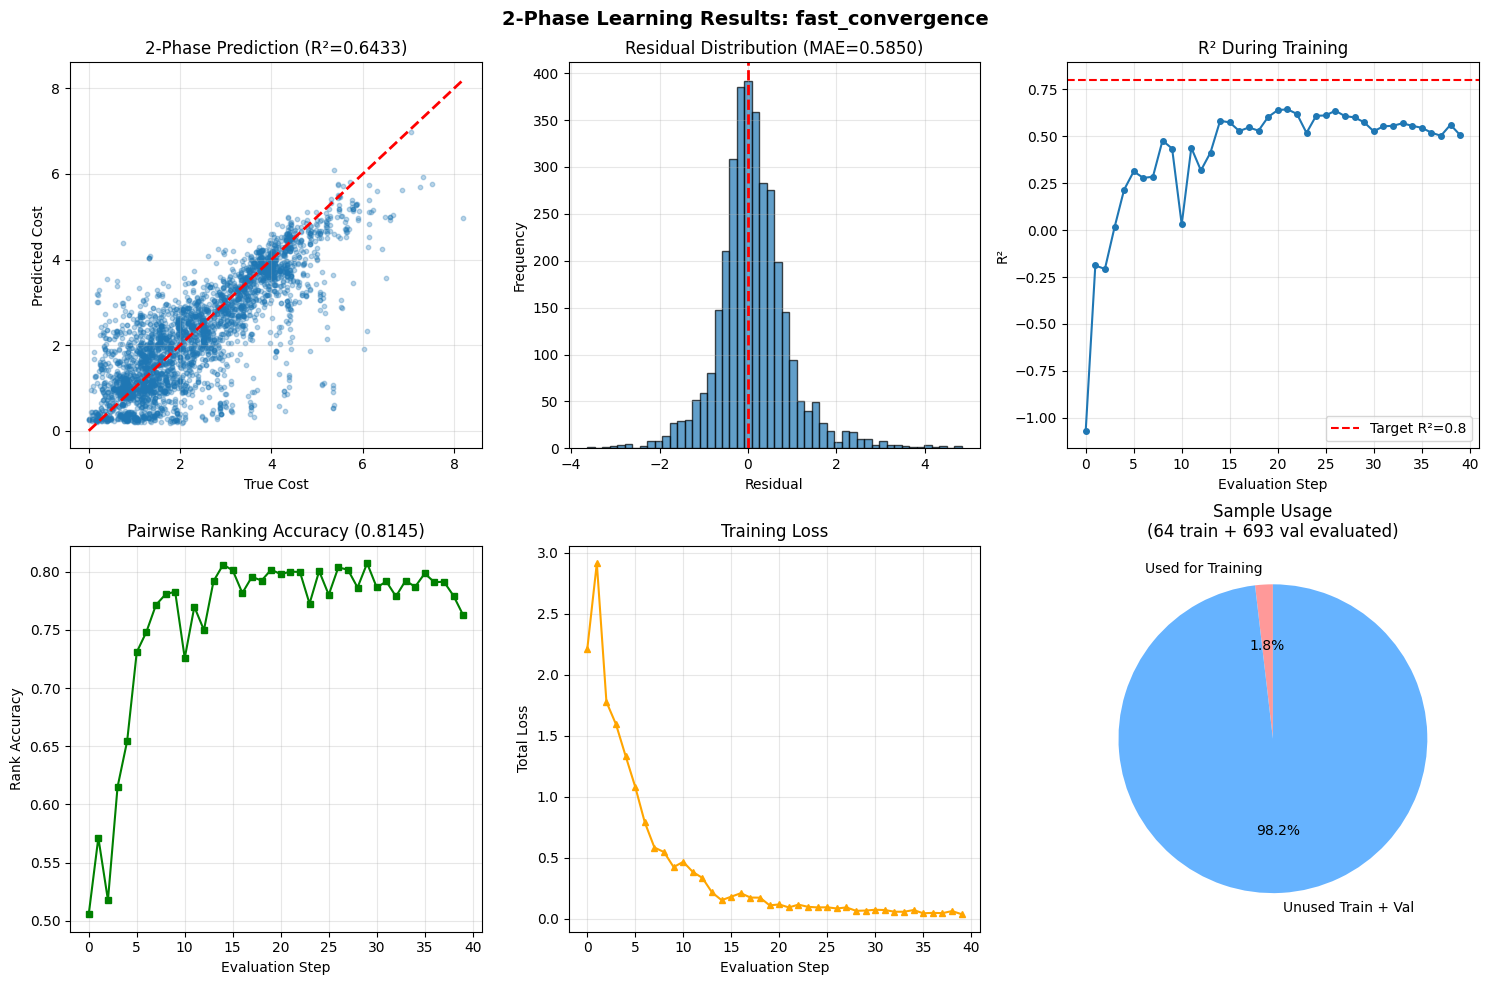


✅ 모델 저장됨: vae_cost_regressor_2phase_best.pth

📋 2 Phase 학습 최종 보고서

🎯 성능 지표:
   - R²: 0.6433
   - Pairwise Rank Accuracy: 0.8145
   - MSE: 0.7022
   - MAE: 0.5850

📊 데이터 사용:
   - 학습에 사용된 샘플: 64개 (Phase 1 + Phase 2)
   - 평가에 사용된 샘플: 3400개 (미사용 train + val)

🔧 최적 하이퍼파라미터:
   - Config: fast_convergence
   - Samples per phase: 64
   - Mini-epochs: 200
   - Encoder LR: 5e-05
   - Predictor LR: 0.005
   - Lambda pair: 0.2
   - Beta (KLD): 0.001

⚠️ 목표 R² 0.8 미달성 (현재: 0.6433)
   추가 개선 방안:
   - 더 많은 samples_per_phase
   - 더 많은 mini_epochs
   - pretrained VAE encoder 교체


In [49]:
# ============================================================
# 📊 최종 결과 시각화 및 모델 저장 (2 Phase 학습)
# ============================================================

import matplotlib.pyplot as plt

# 최고 설정으로 최종 모델 학습
print("=" * 70)
print("🎯 최고 설정으로 최종 모델 학습")
print("=" * 70)

model = VAECostPredictor(
    input_dim=164,
    hidden_dim=checkpoint['config']['hidden_dim'],
    latent_dim=checkpoint['config']['latent_dim'],
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.08
).to(device)
model.load_pretrained_encoder(checkpoint)

final_config = best_result['config']
final_model, final_history, final_metrics, final_used_indices = train_phase_optimized(
    model, train_feature_list, train_segment_sizes, train_labels,
    val_feature_list, val_segment_sizes, val_labels,
    fea_norm_vec, device, final_config,
    samples_per_phase=64,
    mini_epochs=final_config['mini_epochs'],
    target_r2=0.8
)

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. 예측 vs 실제
predictions = final_metrics['predictions']
targets = final_metrics['targets']

axes[0, 0].scatter(targets, predictions, alpha=0.3, s=10)
min_val, max_val = min(targets.min(), predictions.min()), max(targets.max(), predictions.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 0].set_xlabel('True Cost')
axes[0, 0].set_ylabel('Predicted Cost')
axes[0, 0].set_title(f'2-Phase Prediction (R²={final_metrics["r2"]:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. 잔차 분포
residuals = targets - predictions
axes[0, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residual Distribution (MAE={final_metrics["mae"]:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. 학습 곡선 (R²)
if final_history:
    r2_history = [h['r2'] for h in final_history]
    axes[0, 2].plot(r2_history, marker='o', markersize=4)
    axes[0, 2].axhline(0.8, color='r', linestyle='--', label='Target R²=0.8')
    axes[0, 2].set_xlabel('Evaluation Step')
    axes[0, 2].set_ylabel('R²')
    axes[0, 2].set_title('R² During Training')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# 4. Rank Accuracy 히스토리
if final_history:
    rank_history = [h['rank_accuracy'] for h in final_history]
    axes[1, 0].plot(rank_history, marker='s', markersize=4, color='green')
    axes[1, 0].set_xlabel('Evaluation Step')
    axes[1, 0].set_ylabel('Rank Accuracy')
    axes[1, 0].set_title(f'Pairwise Ranking Accuracy ({final_metrics["rank_accuracy"]:.4f})')
    axes[1, 0].grid(True, alpha=0.3)

# 5. Loss 히스토리
if final_history:
    loss_history = [h['total_loss'] for h in final_history]
    axes[1, 1].plot(loss_history, marker='^', markersize=4, color='orange')
    axes[1, 1].set_xlabel('Evaluation Step')
    axes[1, 1].set_ylabel('Total Loss')
    axes[1, 1].set_title('Training Loss')
    axes[1, 1].grid(True, alpha=0.3)

# 6. 샘플 사용률
total_samples = len(train_labels)
used_samples = len(final_used_indices)
unused_samples = total_samples - used_samples + len(val_labels)

labels_pie = ['Used for Training', 'Unused Train + Val']
sizes = [used_samples, unused_samples]
colors = ['#ff9999', '#66b3ff']
axes[1, 2].pie(sizes, labels=labels_pie, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title(f'Sample Usage\n({used_samples} train + {len(val_labels)} val evaluated)')

plt.suptitle(f'2-Phase Learning Results: {final_config["name"]}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('2phase_learning_results.png', dpi=150)
plt.show()

# 모델 저장
save_path_2phase = "vae_cost_regressor_2phase_best.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'config': final_config,
    'metrics': final_metrics,
    'history': final_history,
    'used_indices': final_used_indices,
    'fea_norm_vec': fea_norm_vec.cpu().numpy(),
}, save_path_2phase)

print(f"\n✅ 모델 저장됨: {save_path_2phase}")

# 최종 보고서
print(f"\n{'='*70}")
print("📋 2 Phase 학습 최종 보고서")
print(f"{'='*70}")
print(f"""
🎯 성능 지표:
   - R²: {final_metrics['r2']:.4f}
   - Pairwise Rank Accuracy: {final_metrics['rank_accuracy']:.4f}
   - MSE: {final_metrics['mse']:.4f}
   - MAE: {final_metrics['mae']:.4f}

📊 데이터 사용:
   - 학습에 사용된 샘플: {used_samples}개 (Phase 1 + Phase 2)
   - 평가에 사용된 샘플: {final_metrics['n_total']}개 (미사용 train + val)

🔧 최적 하이퍼파라미터:
   - Config: {final_config['name']}
   - Samples per phase: {64}
   - Mini-epochs: {final_config['mini_epochs']}
   - Encoder LR: {final_config['encoder_lr']}
   - Predictor LR: {final_config['predictor_lr']}
   - Lambda pair: {final_config['lambda_pair']}
   - Beta (KLD): {final_config['beta']}
""")

if final_metrics['r2'] >= 0.8:
    print("🎉 목표 R² 0.8 달성!")
else:
    print(f"⚠️ 목표 R² 0.8 미달성 (현재: {final_metrics['r2']:.4f})")
    print("   추가 개선 방안:")
    print("   - 더 많은 samples_per_phase")
    print("   - 더 많은 mini_epochs")
    print("   - pretrained VAE encoder 교체")

print(f"{'='*70}")

## 🚀 Latent-Space 기반 데이터 증강 학습 (128개 샘플)

### 핵심 전략
- **Train**: 128개 샘플만 사용 (Phase 1: 64개, Phase 2: 64개)
- **Validation**: 나머지 전체 train + val 데이터 사용
- **3가지 효과적인 방법 비교**:
  1. **Method 1**: MSE + Pair Loss + KLD (기본)
  2. **Method 2**: MSE + Pair Loss + Mixup Consistency
  3. **Method 3**: MSE + Pair Loss + Noise Regularization

In [61]:
# ============================================================
# 🎯 128개 샘플 학습용 데이터 준비 (독립 실행 가능)
# ============================================================

import copy
import time
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from glob import glob

# 시드 고정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ============================================================
# 1. Train/Val 분할 (기존 셀의 코드 통합)
# ============================================================
indices = np.arange(len(costs))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=SEED)

train_segment_sizes = segment_sizes[train_indices]
val_segment_sizes = segment_sizes[val_indices]
train_labels = costs[train_indices]
val_labels = costs[val_indices]

train_feature_list = [features_list[i] for i in train_indices]
val_feature_list = [features_list[i] for i in val_indices]

train_flatten_features = np.concatenate(train_feature_list, axis=0).astype(np.float32)
val_flatten_features = np.concatenate(val_feature_list, axis=0).astype(np.float32)

print(f"Train: {len(train_labels)}개, Val: {len(val_labels)}개")
print(f"Train flatten shape: {train_flatten_features.shape}")

# ============================================================
# 2. VAECostPredictor 모델 클래스 정의
# ============================================================
class VAECostPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, latent_dim=64, 
                 predictor_hidden=256, predictor_layers=3, dropout=0.1):
        super(VAECostPredictor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Segment Encoder
        self.segment_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # VAE Encoder
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.l0 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.l1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Cost Predictor
        predictor_modules = []
        current_dim = latent_dim
        for i in range(predictor_layers):
            predictor_modules.extend([
                nn.Linear(current_dim, predictor_hidden),
                nn.BatchNorm1d(predictor_hidden),
                nn.ReLU(),
                nn.Dropout(dropout) if i < predictor_layers - 1 else nn.Identity(),
            ])
            current_dim = predictor_hidden
        predictor_modules.append(nn.Linear(predictor_hidden, 1))
        self.cost_predictor = nn.Sequential(*predictor_modules)
        
    def segment_sum(self, segment_sizes, features):
        n_seg = segment_sizes.shape[0]
        device = features.device
        segment_sizes = segment_sizes.long()
        segment_indices = torch.repeat_interleave(torch.arange(n_seg, device=device), segment_sizes)
        n_dim = features.shape[1]
        segment_sum = torch.scatter_add(
            torch.zeros((n_seg, n_dim), dtype=features.dtype, device=device),
            0, segment_indices.view(-1, 1).expand(-1, n_dim), features,
        )
        return segment_sum
    
    def encode(self, segment_sizes, features):
        h = self.segment_encoder(features)
        segment_sum_vec = self.segment_sum(segment_sizes, h)
        h = self.norm(segment_sum_vec)
        h = self.l0(h) + h
        h = self.l1(h) + h
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar, segment_sum_vec
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def predict_cost(self, z):
        return self.cost_predictor(z).squeeze(-1)
    
    def forward(self, segment_sizes, features, use_mean=False):
        mean, logvar, _ = self.encode(segment_sizes, features)
        z = mean if use_mean else self.reparameterize(mean, logvar)
        cost_pred = self.predict_cost(z)
        return cost_pred, mean, logvar, z

# ============================================================
# 3. Pretrained 모델 로드
# ============================================================
input_dim = train_flatten_features.shape[1]
model = VAECostPredictor(input_dim=input_dim, hidden_dim=256, latent_dim=64).to(device)

# Pretrained 체크포인트 로드
vae_checkpoint_dir = '/root/work/tenset/scripts/pre_experiments/model_final/checkpoints/vae_medium'
vae_files = sorted(glob(f'{vae_checkpoint_dir}/vae_rank8*.pt'))

if len(vae_files) > 0:
    vae_path = vae_files[0]
    checkpoint = torch.load(vae_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        vae_state = checkpoint['model_state_dict']
    else:
        vae_state = checkpoint
    
    encoder_keys = ['segment_encoder', 'norm', 'l0', 'l1', 'fc_mean', 'fc_logvar']
    own_state = model.state_dict()
    loaded = 0
    for name, param in vae_state.items():
        if any(name.startswith(k) for k in encoder_keys):
            if name in own_state and own_state[name].shape == param.shape:
                own_state[name].copy_(param)
                loaded += 1
    model.load_state_dict(own_state)
    print(f"✅ Pretrained VAE encoder 로드: {loaded} parameters from {vae_path}")
else:
    print("⚠️ Pretrained VAE 체크포인트를 찾지 못함. 랜덤 초기화 사용.")

# ============================================================
# 4. Feature 정규화 벡터
# ============================================================
fea_norm_vec = torch.tensor(train_flatten_features.max(axis=0) + 1e-8, dtype=torch.float32)
print(f"Feature 정규화 벡터 shape: {fea_norm_vec.shape}")

# ============================================================
# 5. Validation DataLoader 준비
# ============================================================
from torch.utils.data import Dataset, DataLoader

class SegmentDataset(Dataset):
    def __init__(self, feature_list, segment_sizes, labels, fea_norm_vec=None):
        self.feature_list = feature_list
        self.segment_sizes = segment_sizes
        self.labels = labels
        self.fea_norm_vec = fea_norm_vec
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return idx

def segment_collate_fn(batch_indices, feature_list, segment_sizes, labels, fea_norm_vec=None, device=None):
    batch_features = [feature_list[i] for i in batch_indices]
    batch_segment_sizes = segment_sizes[list(batch_indices)]
    batch_labels = labels[list(batch_indices)]
    
    flatten = np.concatenate(batch_features, axis=0).astype(np.float32)
    seg_tensor = torch.tensor(batch_segment_sizes, dtype=torch.int32)
    fea_tensor = torch.tensor(flatten, dtype=torch.float32)
    lab_tensor = torch.tensor(batch_labels, dtype=torch.float32)
    
    if fea_norm_vec is not None:
        fea_tensor = fea_tensor / fea_norm_vec
    
    if device:
        seg_tensor = seg_tensor.to(device)
        fea_tensor = fea_tensor.to(device)
        lab_tensor = lab_tensor.to(device)
    
    return seg_tensor, fea_tensor, lab_tensor

# Val loader
val_dataset = SegmentDataset(val_feature_list, val_segment_sizes, val_labels)
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False,
    collate_fn=lambda b: segment_collate_fn(b, val_feature_list, val_segment_sizes, val_labels, fea_norm_vec, device)
)
print(f"Val loader: {len(val_loader)} batches")

# ============================================================
# 6. 128개 샘플 선택 (Phase 1: 64개, Phase 2: 64개)
# ============================================================
n_total_train = len(train_labels)
selected_128_indices = np.random.permutation(n_total_train)[:128]
remaining_indices = np.array([i for i in range(n_total_train) if i not in selected_128_indices])

phase1_indices = selected_128_indices[:64]
phase2_indices = selected_128_indices[64:128]

print("\n" + "=" * 60)
print("📊 데이터 분할 (128개 샘플 학습)")
print("=" * 60)
print(f"   전체 Train 데이터: {n_total_train}개")
print(f"   학습용 (128개): Phase1={len(phase1_indices)}개, Phase2={len(phase2_indices)}개")
print(f"   검증용 (나머지): {len(remaining_indices)}개 (train) + {len(val_labels)}개 (val)")

# 배치 텐서 준비 함수
def prepare_batch_tensors(indices, feature_list, segment_sizes, labels, fea_norm_vec, device):
    batch_features = [feature_list[i] for i in indices]
    batch_segment_sizes = segment_sizes[indices]
    batch_labels = labels[indices]
    
    flatten_features = np.concatenate(batch_features, axis=0).astype(np.float32)
    seg_tensor = torch.tensor(batch_segment_sizes, dtype=torch.int32).to(device)
    fea_tensor = torch.tensor(flatten_features, dtype=torch.float32).to(device)
    lab_tensor = torch.tensor(batch_labels, dtype=torch.float32).to(device)
    
    if fea_norm_vec is not None:
        fea_tensor = fea_tensor / fea_norm_vec.to(device)
    
    return seg_tensor, fea_tensor, lab_tensor

# Phase 배치 준비
seg_p1, fea_p1, lab_p1 = prepare_batch_tensors(
    phase1_indices, train_feature_list, train_segment_sizes, train_labels, fea_norm_vec, device
)
seg_p2, fea_p2, lab_p2 = prepare_batch_tensors(
    phase2_indices, train_feature_list, train_segment_sizes, train_labels, fea_norm_vec, device
)

print(f"\n✅ Phase 1 배치: segments={seg_p1.shape}, features={fea_p1.shape}, labels={lab_p1.shape}")
print(f"✅ Phase 2 배치: segments={seg_p2.shape}, features={fea_p2.shape}, labels={lab_p2.shape}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [24]:
# ============================================================
# 🎯 3가지 학습 방법 정의 (128개 샘플용)
# ============================================================

def evaluate_model(model, val_loader, remaining_indices, train_feature_list, 
                   train_segment_sizes, train_labels, fea_norm_vec, device):
    """
    전체 검증 데이터로 모델 평가
    - val_loader: 원래 validation set
    - remaining_indices: 학습에 사용하지 않은 train 데이터
    """
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        # 1. Original validation set
        for seg_sizes, features, labels in val_loader:
            pred, _, _, _ = model(seg_sizes, features, use_mean=True)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
        
        # 2. Remaining train data (배치 처리)
        batch_size = 256
        for i in range(0, len(remaining_indices), batch_size):
            batch_idx = remaining_indices[i:i+batch_size]
            if len(batch_idx) == 0:
                continue
            seg, fea, lab = prepare_batch_tensors(
                batch_idx, train_feature_list, train_segment_sizes, 
                train_labels, fea_norm_vec, device
            )
            pred, _, _, _ = model(seg, fea, use_mean=True)
            all_preds.append(pred.cpu().numpy())
            all_targets.append(lab.cpu().numpy())
    
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    
    mse = np.mean((preds - targets) ** 2)
    r2 = 1 - np.sum((preds - targets) ** 2) / np.sum((targets - targets.mean()) ** 2)
    
    return r2, mse, preds, targets


class Method1_BasicAugmentation:
    """Method 1: MSE + Pair Loss + KLD (기본 VAE 손실)"""
    
    def __init__(self, lambda_pair=0.1, beta=0.001):
        self.lambda_pair = lambda_pair
        self.beta = beta
        self.name = "Method1_Basic"
    
    def compute_loss(self, model, seg_sizes, features, labels):
        pred, mean, logvar, z = model(seg_sizes, features)
        
        # MSE Loss
        mse_loss = F.mse_loss(pred, labels)
        
        # Pair Loss
        pair_loss = torch.tensor(0.0, device=pred.device)
        if len(labels) > 1:
            n_pairs = min(len(labels) * 3, 200)
            idx_i = torch.randint(0, len(labels), (n_pairs,), device=pred.device)
            idx_j = torch.randint(0, len(labels), (n_pairs,), device=pred.device)
            y_diff = labels[idx_i] - labels[idx_j]
            pred_diff = pred[idx_i] - pred[idx_j]
            margin = 0.05
            pair_loss = F.relu(margin - torch.sign(y_diff) * pred_diff).mean()
        
        # KLD Loss
        kld_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        
        total = mse_loss + self.lambda_pair * pair_loss + self.beta * kld_loss
        return total, {'mse': mse_loss.item(), 'pair': pair_loss.item(), 'kld': kld_loss.item()}


class Method2_MixupAugmentation:
    """Method 2: MSE + Pair Loss + Mixup Consistency"""
    
    def __init__(self, lambda_pair=0.1, lambda_mixup=0.2, mixup_alpha=0.4):
        self.lambda_pair = lambda_pair
        self.lambda_mixup = lambda_mixup
        self.mixup_alpha = mixup_alpha
        self.name = "Method2_Mixup"
    
    def compute_loss(self, model, seg_sizes, features, labels):
        pred, mean, logvar, z = model(seg_sizes, features)
        
        # MSE Loss
        mse_loss = F.mse_loss(pred, labels)
        
        # Pair Loss
        pair_loss = torch.tensor(0.0, device=pred.device)
        if len(labels) > 1:
            n_pairs = min(len(labels) * 3, 200)
            idx_i = torch.randint(0, len(labels), (n_pairs,), device=pred.device)
            idx_j = torch.randint(0, len(labels), (n_pairs,), device=pred.device)
            y_diff = labels[idx_i] - labels[idx_j]
            pred_diff = pred[idx_i] - pred[idx_j]
            margin = 0.05
            pair_loss = F.relu(margin - torch.sign(y_diff) * pred_diff).mean()
        
        # Mixup Consistency Loss
        mixup_loss = torch.tensor(0.0, device=pred.device)
        if len(z) > 1:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            perm = torch.randperm(len(z), device=pred.device)
            z_mix = lam * z + (1 - lam) * z[perm]
            y_mix = lam * labels + (1 - lam) * labels[perm]
            pred_mix = model.predict_cost(z_mix)
            mixup_loss = F.mse_loss(pred_mix, y_mix)
        
        total = mse_loss + self.lambda_pair * pair_loss + self.lambda_mixup * mixup_loss
        return total, {'mse': mse_loss.item(), 'pair': pair_loss.item(), 'mixup': mixup_loss.item()}


class Method3_NoiseRegularization:
    """Method 3: MSE + Pair Loss + Noise Regularization"""
    
    def __init__(self, lambda_pair=0.1, lambda_noise=0.15, noise_scales=[0.02, 0.05]):
        self.lambda_pair = lambda_pair
        self.lambda_noise = lambda_noise
        self.noise_scales = noise_scales
        self.name = "Method3_Noise"
    
    def compute_loss(self, model, seg_sizes, features, labels):
        pred, mean, logvar, z = model(seg_sizes, features)
        
        # MSE Loss
        mse_loss = F.mse_loss(pred, labels)
        
        # Pair Loss
        pair_loss = torch.tensor(0.0, device=pred.device)
        if len(labels) > 1:
            n_pairs = min(len(labels) * 3, 200)
            idx_i = torch.randint(0, len(labels), (n_pairs,), device=pred.device)
            idx_j = torch.randint(0, len(labels), (n_pairs,), device=pred.device)
            y_diff = labels[idx_i] - labels[idx_j]
            pred_diff = pred[idx_i] - pred[idx_j]
            margin = 0.05
            pair_loss = F.relu(margin - torch.sign(y_diff) * pred_diff).mean()
        
        # Noise Regularization Loss
        noise_loss = torch.tensor(0.0, device=pred.device)
        if len(z) > 1:
            for scale in self.noise_scales:
                noise = torch.randn_like(z) * scale
                z_noisy = z + noise
                pred_noisy = model.predict_cost(z_noisy)
                # 작은 노이즈에 대해 예측이 안정적이어야 함
                noise_loss = noise_loss + F.mse_loss(pred_noisy, pred.detach())
            noise_loss = noise_loss / len(self.noise_scales)
        
        total = mse_loss + self.lambda_pair * pair_loss + self.lambda_noise * noise_loss
        return total, {'mse': mse_loss.item(), 'pair': pair_loss.item(), 'noise': noise_loss.item()}


print("✅ 3가지 학습 방법 정의 완료")
print("   - Method1_Basic: MSE + Pair + KLD")
print("   - Method2_Mixup: MSE + Pair + Mixup Consistency")
print("   - Method3_Noise: MSE + Pair + Noise Regularization")

✅ 3가지 학습 방법 정의 완료
   - Method1_Basic: MSE + Pair + KLD
   - Method2_Mixup: MSE + Pair + Mixup Consistency
   - Method3_Noise: MSE + Pair + Noise Regularization


In [25]:
# ============================================================
# 🎯 128개 샘플 2-Phase 학습 함수
# ============================================================

def train_128_samples(model, method, phase1_data, phase2_data, 
                      val_loader, remaining_indices, train_feature_list,
                      train_segment_sizes, train_labels, fea_norm_vec, device,
                      n_epochs=100, lr=1e-4, patience=20, verbose=True):
    """
    128개 샘플로 2-Phase 학습
    
    Args:
        model: VAECostPredictor
        method: 학습 방법 (Method1, Method2, Method3)
        phase1_data: (seg, fea, lab) for phase 1 (64 samples)
        phase2_data: (seg, fea, lab) for phase 2 (64 samples)
        val_loader: validation data loader
        remaining_indices: 학습에 사용하지 않은 train 인덱스
        n_epochs: 에폭 수
        lr: learning rate
        patience: early stopping patience
    
    Returns:
        best_state: 최고 성능 모델 상태
        history: 학습 히스토리
    """
    seg_p1, fea_p1, lab_p1 = phase1_data
    seg_p2, fea_p2, lab_p2 = phase2_data
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)
    
    history = {'train_loss': [], 'val_r2': [], 'val_mse': [], 'components': []}
    best_r2 = -float('inf')
    best_mse = float('inf')
    best_state = None
    no_improve = 0
    
    start_time = time.time()
    
    for epoch in range(n_epochs):
        model.train()
        
        # Phase 1: 64개 샘플 학습
        optimizer.zero_grad()
        loss1, comp1 = method.compute_loss(model, seg_p1, fea_p1, lab_p1)
        loss1.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Phase 2: 다음 64개 샘플 학습
        optimizer.zero_grad()
        loss2, comp2 = method.compute_loss(model, seg_p2, fea_p2, lab_p2)
        loss2.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        scheduler.step()
        
        avg_loss = (loss1.item() + loss2.item()) / 2
        history['train_loss'].append(avg_loss)
        history['components'].append({'p1': comp1, 'p2': comp2})
        
        # Validation (전체 검증 데이터)
        r2, mse, _, _ = evaluate_model(
            model, val_loader, remaining_indices, train_feature_list,
            train_segment_sizes, train_labels, fea_norm_vec, device
        )
        history['val_r2'].append(r2)
        history['val_mse'].append(mse)
        
        if r2 > best_r2:
            best_r2 = r2
            best_mse = mse
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
        
        if verbose and (epoch % 20 == 0 or epoch < 5 or r2 > best_r2 - 0.001):
            elapsed = time.time() - start_time
            print(f"[Epoch {epoch+1:3d}] loss={avg_loss:.4f} | R²={r2:.5f} MSE={mse:.5f} | Best={best_r2:.5f} ({elapsed:.1f}s)")
        
        if no_improve >= patience:
            if verbose:
                print(f"⚠️ Early stopping at epoch {epoch+1}")
            break
    
    return best_state, history, {'best_r2': best_r2, 'best_mse': best_mse}


print("✅ train_128_samples 함수 정의 완료")

✅ train_128_samples 함수 정의 완료


In [26]:
# ============================================================
# 🎯 Method 1: Basic Augmentation (MSE + Pair + KLD) 학습
# ============================================================

print("=" * 70)
print("🔄 Method 1: MSE + Pair Loss + KLD")
print("=" * 70)

# 새 모델 생성 및 초기화
model_m1 = VAECostPredictor(
    input_dim=input_dim,
    hidden_dim=256,
    latent_dim=64,
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.1
).to(device)

# Pretrained encoder 로드
model_m1.load_state_dict(model.state_dict())

method1 = Method1_BasicAugmentation(lambda_pair=0.15, beta=0.0005)

state_m1, history_m1, metrics_m1 = train_128_samples(
    model=model_m1,
    method=method1,
    phase1_data=(seg_p1, fea_p1, lab_p1),
    phase2_data=(seg_p2, fea_p2, lab_p2),
    val_loader=val_loader,
    remaining_indices=remaining_indices,
    train_feature_list=train_feature_list,
    train_segment_sizes=train_segment_sizes,
    train_labels=train_labels,
    fea_norm_vec=fea_norm_vec,
    device=device,
    n_epochs=150,
    lr=5e-5,
    patience=30,
    verbose=True
)

print(f"\n✅ Method 1 완료: Best R² = {metrics_m1['best_r2']:.5f}, MSE = {metrics_m1['best_mse']:.5f}")

🔄 Method 1: MSE + Pair Loss + KLD
[Epoch   1] loss=8.8722 | R²=-3.06118 MSE=7.93327 | Best=-3.06118 (0.1s)
[Epoch   2] loss=8.9497 | R²=-3.07801 MSE=7.96615 | Best=-3.06118 (0.1s)
[Epoch   3] loss=8.7806 | R²=-3.06230 MSE=7.93545 | Best=-3.06118 (0.1s)
[Epoch   4] loss=8.8478 | R²=-3.02745 MSE=7.86739 | Best=-3.02745 (0.2s)
[Epoch   5] loss=8.5779 | R²=-2.99974 MSE=7.81325 | Best=-2.99974 (0.2s)
[Epoch   6] loss=8.5508 | R²=-2.97686 MSE=7.76856 | Best=-2.97686 (0.2s)
[Epoch   7] loss=8.2565 | R²=-2.97567 MSE=7.76623 | Best=-2.97567 (0.3s)
[Epoch   8] loss=8.2572 | R²=-2.97174 MSE=7.75856 | Best=-2.97174 (0.3s)
[Epoch  11] loss=8.1060 | R²=-2.96439 MSE=7.74420 | Best=-2.96439 (0.4s)
[Epoch  14] loss=7.8662 | R²=-2.94910 MSE=7.71432 | Best=-2.94910 (0.5s)
[Epoch  21] loss=7.0206 | R²=-2.98134 MSE=7.77731 | Best=-2.94910 (0.7s)
[Epoch  25] loss=6.6731 | R²=-2.91460 MSE=7.64693 | Best=-2.91460 (0.8s)
[Epoch  26] loss=6.6548 | R²=-2.89328 MSE=7.60528 | Best=-2.89328 (0.9s)
[Epoch  27] loss=

In [27]:
# ============================================================
# 🎯 Method 2: Mixup Augmentation 학습
# ============================================================

print("=" * 70)
print("🔄 Method 2: MSE + Pair Loss + Mixup Consistency")
print("=" * 70)

# 새 모델 생성 및 초기화
model_m2 = VAECostPredictor(
    input_dim=input_dim,
    hidden_dim=256,
    latent_dim=64,
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.1
).to(device)

# Pretrained encoder 로드
model_m2.load_state_dict(model.state_dict())

method2 = Method2_MixupAugmentation(lambda_pair=0.15, lambda_mixup=0.25, mixup_alpha=0.4)

state_m2, history_m2, metrics_m2 = train_128_samples(
    model=model_m2,
    method=method2,
    phase1_data=(seg_p1, fea_p1, lab_p1),
    phase2_data=(seg_p2, fea_p2, lab_p2),
    val_loader=val_loader,
    remaining_indices=remaining_indices,
    train_feature_list=train_feature_list,
    train_segment_sizes=train_segment_sizes,
    train_labels=train_labels,
    fea_norm_vec=fea_norm_vec,
    device=device,
    n_epochs=150,
    lr=5e-5,
    patience=30,
    verbose=True
)

print(f"\n✅ Method 2 완료: Best R² = {metrics_m2['best_r2']:.5f}, MSE = {metrics_m2['best_mse']:.5f}")

🔄 Method 2: MSE + Pair Loss + Mixup Consistency
[Epoch   1] loss=11.1226 | R²=-3.09070 MSE=7.99093 | Best=-3.09070 (0.0s)
[Epoch   2] loss=10.8749 | R²=-3.07415 MSE=7.95861 | Best=-3.07415 (0.1s)
[Epoch   3] loss=10.8051 | R²=-2.99056 MSE=7.79532 | Best=-2.99056 (0.1s)
[Epoch   4] loss=10.7913 | R²=-2.99110 MSE=7.79637 | Best=-2.99056 (0.1s)
[Epoch   5] loss=10.3265 | R²=-2.96514 MSE=7.74566 | Best=-2.96514 (0.2s)
[Epoch  21] loss=8.8030 | R²=-3.09036 MSE=7.99028 | Best=-2.96514 (0.7s)
[Epoch  33] loss=7.2031 | R²=-2.93800 MSE=7.69264 | Best=-2.93800 (1.1s)
[Epoch  34] loss=7.1382 | R²=-2.90034 MSE=7.61909 | Best=-2.90034 (1.1s)
[Epoch  35] loss=7.0339 | R²=-2.85834 MSE=7.53703 | Best=-2.85834 (1.1s)
[Epoch  38] loss=6.8295 | R²=-2.85196 MSE=7.52456 | Best=-2.85196 (1.2s)
[Epoch  39] loss=6.6684 | R²=-2.85112 MSE=7.52293 | Best=-2.85112 (1.3s)
[Epoch  40] loss=6.6227 | R²=-2.76427 MSE=7.35328 | Best=-2.76427 (1.3s)
[Epoch  41] loss=6.5076 | R²=-2.66827 MSE=7.16574 | Best=-2.66827 (1.3s

In [28]:
# ============================================================
# 🎯 Method 3: Noise Regularization 학습
# ============================================================

print("=" * 70)
print("🔄 Method 3: MSE + Pair Loss + Noise Regularization")
print("=" * 70)

# 새 모델 생성 및 초기화
model_m3 = VAECostPredictor(
    input_dim=input_dim,
    hidden_dim=256,
    latent_dim=64,
    predictor_hidden=256,
    predictor_layers=3,
    dropout=0.1
).to(device)

# Pretrained encoder 로드
model_m3.load_state_dict(model.state_dict())

method3 = Method3_NoiseRegularization(lambda_pair=0.15, lambda_noise=0.2, noise_scales=[0.02, 0.05, 0.1])

state_m3, history_m3, metrics_m3 = train_128_samples(
    model=model_m3,
    method=method3,
    phase1_data=(seg_p1, fea_p1, lab_p1),
    phase2_data=(seg_p2, fea_p2, lab_p2),
    val_loader=val_loader,
    remaining_indices=remaining_indices,
    train_feature_list=train_feature_list,
    train_segment_sizes=train_segment_sizes,
    train_labels=train_labels,
    fea_norm_vec=fea_norm_vec,
    device=device,
    n_epochs=150,
    lr=5e-5,
    patience=30,
    verbose=True
)

print(f"\n✅ Method 3 완료: Best R² = {metrics_m3['best_r2']:.5f}, MSE = {metrics_m3['best_mse']:.5f}")

🔄 Method 3: MSE + Pair Loss + Noise Regularization
[Epoch   1] loss=8.8715 | R²=-3.05516 MSE=7.92151 | Best=-3.05516 (0.0s)
[Epoch   2] loss=8.9635 | R²=-2.92086 MSE=7.65917 | Best=-2.92086 (0.1s)
[Epoch   3] loss=8.6911 | R²=-2.92553 MSE=7.66828 | Best=-2.92086 (0.1s)
[Epoch   4] loss=8.6308 | R²=-2.95974 MSE=7.73512 | Best=-2.92086 (0.2s)
[Epoch   5] loss=8.7376 | R²=-2.95432 MSE=7.72452 | Best=-2.92086 (0.2s)
[Epoch   6] loss=8.5228 | R²=-2.80952 MSE=7.44167 | Best=-2.80952 (0.2s)
[Epoch  21] loss=7.0738 | R²=-3.19835 MSE=8.20123 | Best=-2.80952 (0.7s)
[Epoch  34] loss=5.9020 | R²=-2.80026 MSE=7.42359 | Best=-2.80026 (1.1s)
[Epoch  35] loss=5.7505 | R²=-2.72605 MSE=7.27862 | Best=-2.72605 (1.2s)
[Epoch  37] loss=5.5796 | R²=-2.68724 MSE=7.20279 | Best=-2.68724 (1.2s)
[Epoch  39] loss=5.4765 | R²=-2.66925 MSE=7.16767 | Best=-2.66925 (1.3s)
[Epoch  40] loss=5.4724 | R²=-2.63668 MSE=7.10404 | Best=-2.63668 (1.4s)
[Epoch  41] loss=5.4776 | R²=-2.62359 MSE=7.07847 | Best=-2.62359 (1.4s)


📊 3가지 방법 비교 결과
📌 Baseline (학습 전): R² = -2.94084, MSE = 7.69820

   Method 1 (Basic): R² = -1.63833, MSE = 5.15383
   Method 2 (Mixup): R² = -1.78850, MSE = 5.44717
   Method 3 (Noise): R² = -1.62937, MSE = 5.13632


/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_54731/2203922425.py:85

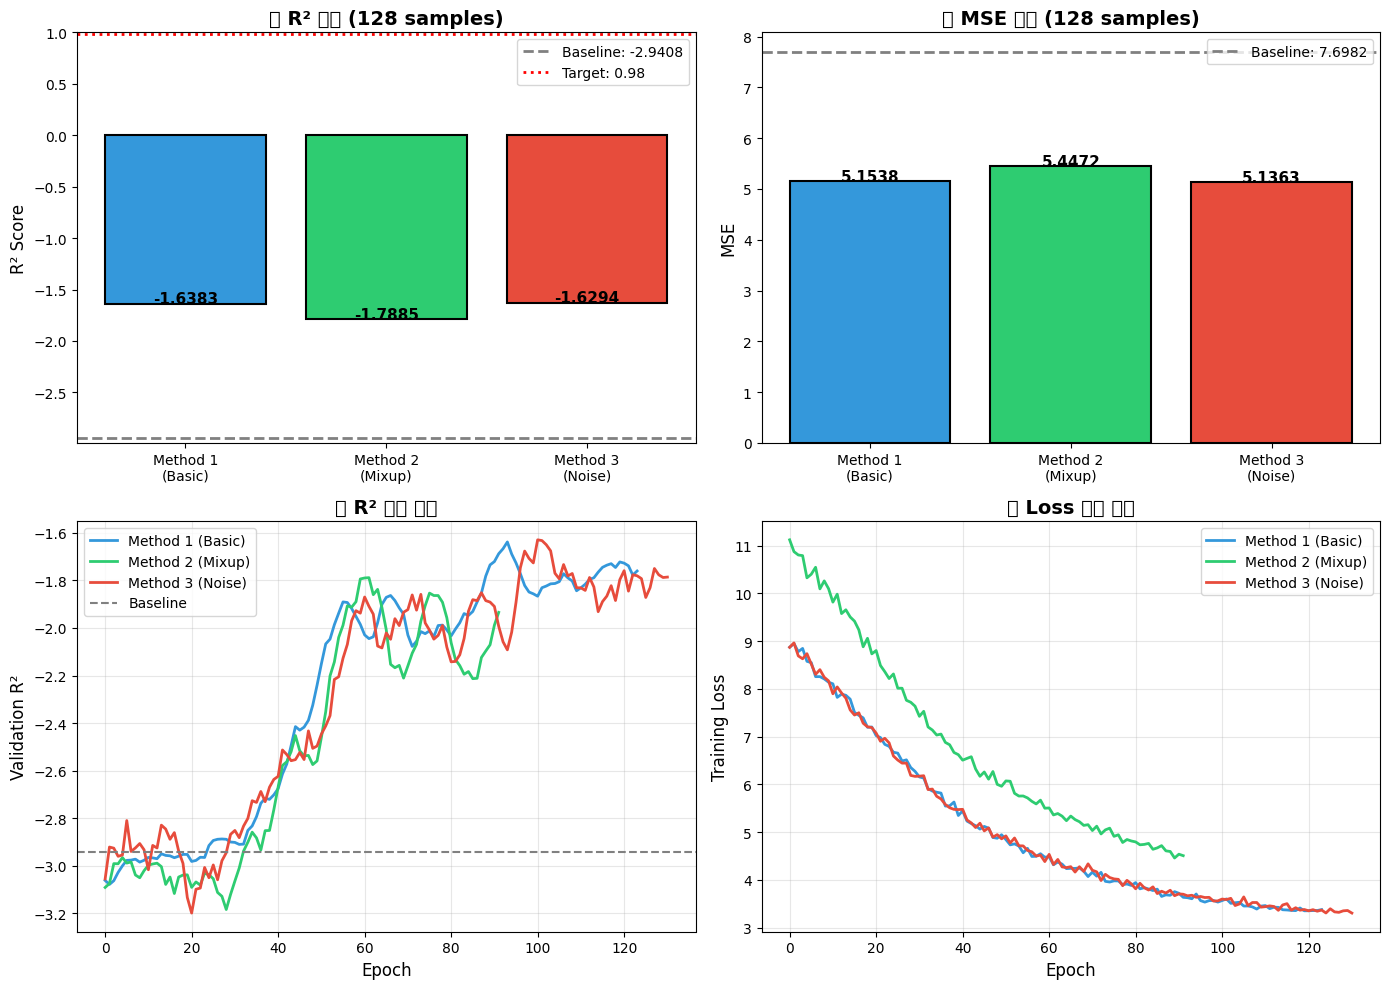


📋 최종 결과 요약 (128개 샘플 학습)
   🏆 최고 성능: Method 3 (Noise) (R² = -1.62937)
   📈 Baseline 대비 개선: R² -2.94084 → -1.62937
   💡 학습 샘플: 128개 (전체의 4.62%)


In [29]:
# ============================================================
# 📊 결과 비교 시각화
# ============================================================

import matplotlib.pyplot as plt

print("=" * 70)
print("📊 3가지 방법 비교 결과")
print("=" * 70)

# 결과 요약
results = {
    'Method 1\n(Basic)': metrics_m1,
    'Method 2\n(Mixup)': metrics_m2,
    'Method 3\n(Noise)': metrics_m3
}

# Baseline (학습 전)
model.eval()
with torch.no_grad():
    baseline_r2, baseline_mse, _, _ = evaluate_model(
        model, val_loader, remaining_indices, train_feature_list,
        train_segment_sizes, train_labels, fea_norm_vec, device
    )
print(f"📌 Baseline (학습 전): R² = {baseline_r2:.5f}, MSE = {baseline_mse:.5f}")
print()

for name, metrics in results.items():
    print(f"   {name.replace(chr(10), ' ')}: R² = {metrics['best_r2']:.5f}, MSE = {metrics['best_mse']:.5f}")

# Figure 생성
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. R² 비교 (Bar Chart)
ax1 = axes[0, 0]
methods = list(results.keys())
r2_values = [results[m]['best_r2'] for m in methods]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(methods, r2_values, color=colors, edgecolor='black', linewidth=1.5)
ax1.axhline(y=baseline_r2, color='gray', linestyle='--', linewidth=2, label=f'Baseline: {baseline_r2:.4f}')
ax1.axhline(y=0.98, color='red', linestyle=':', linewidth=2, label='Target: 0.98')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('📊 R² 비교 (128 samples)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.set_ylim([min(baseline_r2, min(r2_values)) - 0.05, 1.0])
for bar, val in zip(bars, r2_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# 2. MSE 비교 (Bar Chart)
ax2 = axes[0, 1]
mse_values = [results[m]['best_mse'] for m in methods]
bars = ax2.bar(methods, mse_values, color=colors, edgecolor='black', linewidth=1.5)
ax2.axhline(y=baseline_mse, color='gray', linestyle='--', linewidth=2, label=f'Baseline: {baseline_mse:.4f}')
ax2.set_ylabel('MSE', fontsize=12)
ax2.set_title('📊 MSE 비교 (128 samples)', fontsize=14, fontweight='bold')
ax2.legend()
for bar, val in zip(bars, mse_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# 3. R² 학습 곡선
ax3 = axes[1, 0]
ax3.plot(history_m1['val_r2'], label='Method 1 (Basic)', color='#3498db', linewidth=2)
ax3.plot(history_m2['val_r2'], label='Method 2 (Mixup)', color='#2ecc71', linewidth=2)
ax3.plot(history_m3['val_r2'], label='Method 3 (Noise)', color='#e74c3c', linewidth=2)
ax3.axhline(y=baseline_r2, color='gray', linestyle='--', label='Baseline')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Validation R²', fontsize=12)
ax3.set_title('📈 R² 학습 곡선', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Loss 학습 곡선
ax4 = axes[1, 1]
ax4.plot(history_m1['train_loss'], label='Method 1 (Basic)', color='#3498db', linewidth=2)
ax4.plot(history_m2['train_loss'], label='Method 2 (Mixup)', color='#2ecc71', linewidth=2)
ax4.plot(history_m3['train_loss'], label='Method 3 (Noise)', color='#e74c3c', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Training Loss', fontsize=12)
ax4.set_title('📉 Loss 학습 곡선', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('latent_augmentation_comparison_128samples.png', dpi=150, bbox_inches='tight')
plt.show()

# 최종 결과 요약
print("\n" + "=" * 70)
print("📋 최종 결과 요약 (128개 샘플 학습)")
print("=" * 70)
best_method = max(results.keys(), key=lambda m: results[m]['best_r2'])
best_r2 = results[best_method]['best_r2']
improvement = (best_r2 - baseline_r2) / abs(baseline_r2) * 100 if baseline_r2 != 0 else 0

print(f"   🏆 최고 성능: {best_method.replace(chr(10), ' ')} (R² = {best_r2:.5f})")
print(f"   📈 Baseline 대비 개선: R² {baseline_r2:.5f} → {best_r2:.5f}")
print(f"   💡 학습 샘플: 128개 (전체의 {128/n_total_train*100:.2f}%)")
print("=" * 70)